# Analysis of GDP Growth vs. Inflation in Canada (1961-2025)

### Project Overview
This notebook explores the relationship between Real GDP growth and inflation in Canada using quarterly data spanning over 60 years. The primary goal is to test the common economic hypothesis that higher GDP growth is associated with higher inflation.

The analysis involves a comprehensive data science workflow:

- **Data Sourcing**: Using raw, real-world data from Statistics Canada.

- **Data Cleaning**: Handling complex file structures, inconsistent date formats, and reshaping the data for analysis.

- **Feature Engineering**: Calculating Quarter-over-Quarter (QoQ) and Year-over-Year (YoY) metrics to view the relationship from both a short-term and long-term perspective.

- **Visualization & Analysis**: Creating a multi-plot dashboard to visualize the findings and calculating statistical correlations to draw a final, data-driven conclusion.

**Data Sources:**

- **GDP Data**: Statistics Canada, Table 36-10-0104-01 (Pre-calculated quarterly % change).

- **CPI Data**: Statistics Canada, Table 18-10-0004-01 (Consumer Price Index, 2002=100).

## 1. Setup: Importing Libraries and Loading Data
We begin by importing the necessary Python libraries (`pandas` for data manipulation, `matplotlib` for plotting, and `numpy` for numerical operations) and loading the raw GDP dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the GDP data
gdp_df = pd.read_csv('gdp.csv')
print("GDP data shape:", gdp_df.shape)
print("GDP data head:")
gdp_df.head()

GDP data shape: (1, 258)
GDP data head:


,Estimates,Q2 1961,Q3 1961,Q4 1961,Q1 1962,Q2 1962,Q3 1962,Q4 1962,Q1 1963,Q2 1963,...,Q1 2023,Q2 2023,Q3 2023,Q4 2023,Q1 2024,Q2 2024,Q3 2024,Q4 2024,Q1 2025,Q2 2025
0,Gross domestic product at market prices,2.532,2.433,1.361,2.661,0.795,1.279,1.962,0.634,1.454,...,0.967,0.207,-0.138,0.175,0.532,0.631,0.596,0.51,0.504,-0.398


## 2. GDP Data Processing
The raw GDP data is in a wide format and needs to be reshaped. The values in the provided file represent the pre-calculated quarterly growth rates, which is the primary metric we need. We will reshape the data, clean it, and format the date index to represent the end of each quarter.

In [2]:
# Reshape GDP data:
# GDP values are already growth rates!
gdp_long = gdp_df.melt(id_vars=['Estimates'], var_name='Date', value_name='GDP_Growth_Rate')
gdp_long.drop(columns=['Estimates'], inplace=True)

def convert_gdp_quarter(date_string):
    """
    Convert quarter format like 'Q2 1961' to end-of-quarter date
    """
    quarter, year = date_string.split(" ")
    if quarter == "Q1":
        return f"{year}-03-31"
    elif quarter == "Q2":
        return f"{year}-06-30"
    elif quarter == "Q3":
        return f"{year}-09-30"
    elif quarter == "Q4":
        return f"{year}-12-31"

# Apply date conversion
gdp_long['Date'] = gdp_long['Date'].apply(convert_gdp_quarter)
gdp_long['Date'] = pd.to_datetime(gdp_long['Date'])
gdp_long.set_index('Date', inplace=True)

print("\nGDP Growth Rate Statistics (these are already percentages):")
print(gdp_long['GDP_Growth_Rate'].describe())
print("\nSample GDP growth rates:")
gdp_long['GDP_Growth_Rate'].head(10)


GDP Growth Rate Statistics (these are already percentages):
count    257.00000
mean       0.75179
std        1.23997
min      -11.00000
25%        0.28000
50%        0.72700
75%        1.26900
max        9.08400
Name: GDP_Growth_Rate, dtype: float64

Sample GDP growth rates:


Date
1961-06-30    2.532
1961-09-30    2.433
1961-12-31    1.361
1962-03-31    2.661
1962-06-30    0.795
1962-09-30    1.279
1962-12-31    1.962
1963-03-31    0.634
1963-06-30    1.454
1963-09-30    0.760
Name: GDP_Growth_Rate, dtype: float64

## 3. CPI Data Processing
Next, we load and process the Consumer Price Index (CPI) data. This involves several key steps:

1.  Isolating the "All-items" CPI, which represents overall inflation.

2.  Reshaping the data from wide to long format.

3.  Implementing a robust date-cleaning function to handle multiple historical date formats (e.g., 'Jan-62' vs. '01-Jan').

4.  Converting the cleaned monthly data into a quarterly series to match the GDP data.

In [3]:
# Load CPI data
cpi_df = pd.read_csv('cpi.csv')
print("CPI data shape:", cpi_df.shape)
print("CPI data head:")
cpi_df.head()

CPI data shape: (1, 774)
CPI data head:


,Date,Mar-61,Apr-61,May-61,Jun-61,Jul-61,Aug-61,Sep-61,Oct-61,Nov-61,...,Oct-24,Nov-24,Dec-24,Jan-25,Feb-25,Mar-25,Apr-25,May-25,Jun-25,Jul-25
0,All-items,15.7,15.7,15.7,15.7,15.7,15.7,15.7,15.7,15.7,...,161.8,161.8,161.2,161.3,163,163.5,163.4,164.3,164.4,164.9


In [4]:
# Extract all items CPI
cpi_all_items = cpi_df.iloc[[0]]  # This gets the "All-items" row
cpi_all_items_long = cpi_all_items.melt(id_vars=['Date'], var_name='Month', value_name='CPI_Value')
cpi_all_items_long.drop(columns=['Date'], inplace=True)

def fix_year(date_string):
    """
    Fix 2-digit years to 4-digit years
    """
    # Handle different date formats in data
    parts = date_string.split('-')
    year = parts[1]

    # If the year is a 2-digit number and it's greater than 50 (like '61', '99')
    if len(year) == 2 and int(year) > 50:
        # Add "19" to the front
        new_year = '19' + year
    else:
        # Otherwise, add "20" (for years like '01', '23')
        new_year = '20' + year

    # Return the corrected string, e.g., "Jan-1961"
    return f"{parts[0]}-{new_year}"

# Process CPI dates
cpi_all_items_long['Month'] = cpi_all_items_long['Month'].astype(str).apply(fix_year)

# Convert to datetime
cpi_all_items_long['Month'] = pd.to_datetime(cpi_all_items_long['Month'], format='%b-%Y')

print("\nCPI data sample after date processing (Base year 2002 = 100):")
print(cpi_all_items_long.head(10))
print(cpi_all_items_long.tail(10))


CPI data sample after date processing (Base year 2002 = 100):
       Month  CPI_Value
0 1961-03-01       15.7
1 1961-04-01       15.7
2 1961-05-01       15.7
3 1961-06-01       15.7
4 1961-07-01       15.7
5 1961-08-01       15.7
6 1961-09-01       15.7
7 1961-10-01       15.7
8 1961-11-01       15.7
9 1961-12-01       15.7
         Month  CPI_Value
763 2024-10-01      161.8
764 2024-11-01      161.8
765 2024-12-01      161.2
766 2025-01-01      161.3
767 2025-02-01      163.0
768 2025-03-01      163.5
769 2025-04-01      163.4
770 2025-05-01      164.3
771 2025-06-01      164.4
772 2025-07-01      164.9


In [5]:
# Convert monthly CPI to quarterly (using end of quarter average)
cpi_quarterly = cpi_all_items_long.set_index('Month').resample('QE').mean()

print("CPI Quarterly sample:")
cpi_quarterly.head(10)

CPI Quarterly sample:


,CPI_Value
Month,
1961-03-31,15.700000
1961-06-30,15.700000
1961-09-30,15.700000
1961-12-31,15.700000
1962-03-31,15.700000
1962-06-30,15.833333
1962-09-30,15.933333
1962-12-31,16.000000
1963-03-31,16.000000


## 4. Merge Data and Calculate Final Metrics
With both datasets cleaned and indexed by quarter, we merge them into a single DataFrame. We then calculate our final analysis metrics:

- **`Inflation_Rate_QoQ`**: The Quarter-over-Quarter inflation rate.

- **`Inflation_Rate_YoY`**: The Year-over-Year inflation rate for a longer-term view.

- **`GDP_Growth_Rate_YoY`**: A 4-quarter rolling average of GDP growth to match the YoY inflation perspective.

In [6]:
# Merge GDP and CPI data
final_df = pd.merge(gdp_long, cpi_quarterly, left_index=True, right_index=True, how='inner')

print(f"Merged data shape: {final_df.shape}")
print("Merged data head:")
final_df.head(10)

Merged data shape: (257, 2)
Merged data head:


,GDP_Growth_Rate,CPI_Value
1961-06-30,2.532,15.700000
1961-09-30,2.433,15.700000
1961-12-31,1.361,15.700000
1962-03-31,2.661,15.700000
1962-06-30,0.795,15.833333
1962-09-30,1.279,15.933333
1962-12-31,1.962,16.000000
1963-03-31,0.634,16.000000
1963-06-30,1.454,16.000000
1963-09-30,0.760,16.233333


In [7]:
# Calculate inflation rates from CPI values (Base year 2002 = 100)
final_df['Inflation_Rate_QoQ'] = final_df['CPI_Value'].pct_change() * 100  # Quarter-over-quarter
final_df['Inflation_Rate_YoY'] = final_df['CPI_Value'].pct_change(periods=4) * 100  # Year-over-year

# GDP is already in growth rate format, also calculate YoY for comparison
# For YoY GDP growth, we can use rolling average of 4 quarters
final_df['GDP_Growth_Rate_YoY'] = final_df['GDP_Growth_Rate'].rolling(window=4).mean()

# Annualize the quarterly inflation rate
final_df['Inflation_Rate_Annualized'] = ((1 + final_df['CPI_Value'].pct_change()) ** 4 - 1) * 100

# Remove NaN values created by percentage change and rolling calculations
final_df_clean = final_df.dropna()

print("Final data statistics:")
print("GDP Growth Rate (Quarterly) stats:", final_df_clean['GDP_Growth_Rate'].describe())
print("GDP Growth Rate (YoY rolling avg) stats:", final_df_clean['GDP_Growth_Rate_YoY'].describe())
print("Inflation Rate (QoQ) stats:", final_df_clean['Inflation_Rate_QoQ'].describe())
print("Inflation Rate (YoY) stats:", final_df_clean['Inflation_Rate_YoY'].describe())

Final data statistics:
GDP Growth Rate (Quarterly) stats: count    253.000000
mean       0.728154
std        1.233548
min      -11.000000
25%        0.241000
50%        0.723000
75%        1.239000
max        9.084000
Name: GDP_Growth_Rate, dtype: float64
GDP Growth Rate (YoY rolling avg) stats: count    253.000000
mean       0.740816
std        0.639476
min       -3.096000
25%        0.435500
50%        0.766250
75%        1.110750
max        3.137250
Name: GDP_Growth_Rate_YoY, dtype: float64
Inflation Rate (QoQ) stats: count    253.000000
mean       0.935356
std        0.856927
min       -1.498127
25%        0.364875
50%        0.790330
75%        1.379116
max        3.475936
Name: Inflation_Rate_QoQ, dtype: float64
Inflation Rate (YoY) stats: count    253.000000
mean       3.805540
std        2.987379
min       -0.864304
25%        1.744569
50%        2.695800
75%        4.726127
max       12.696042
Name: Inflation_Rate_YoY, dtype: float64


## 5. Data Visualization
Now we create a 2x2 dashboard to visualize our findings. This provides a comprehensive view of the relationships (via scatter plots) and historical trends (via time-series plots).

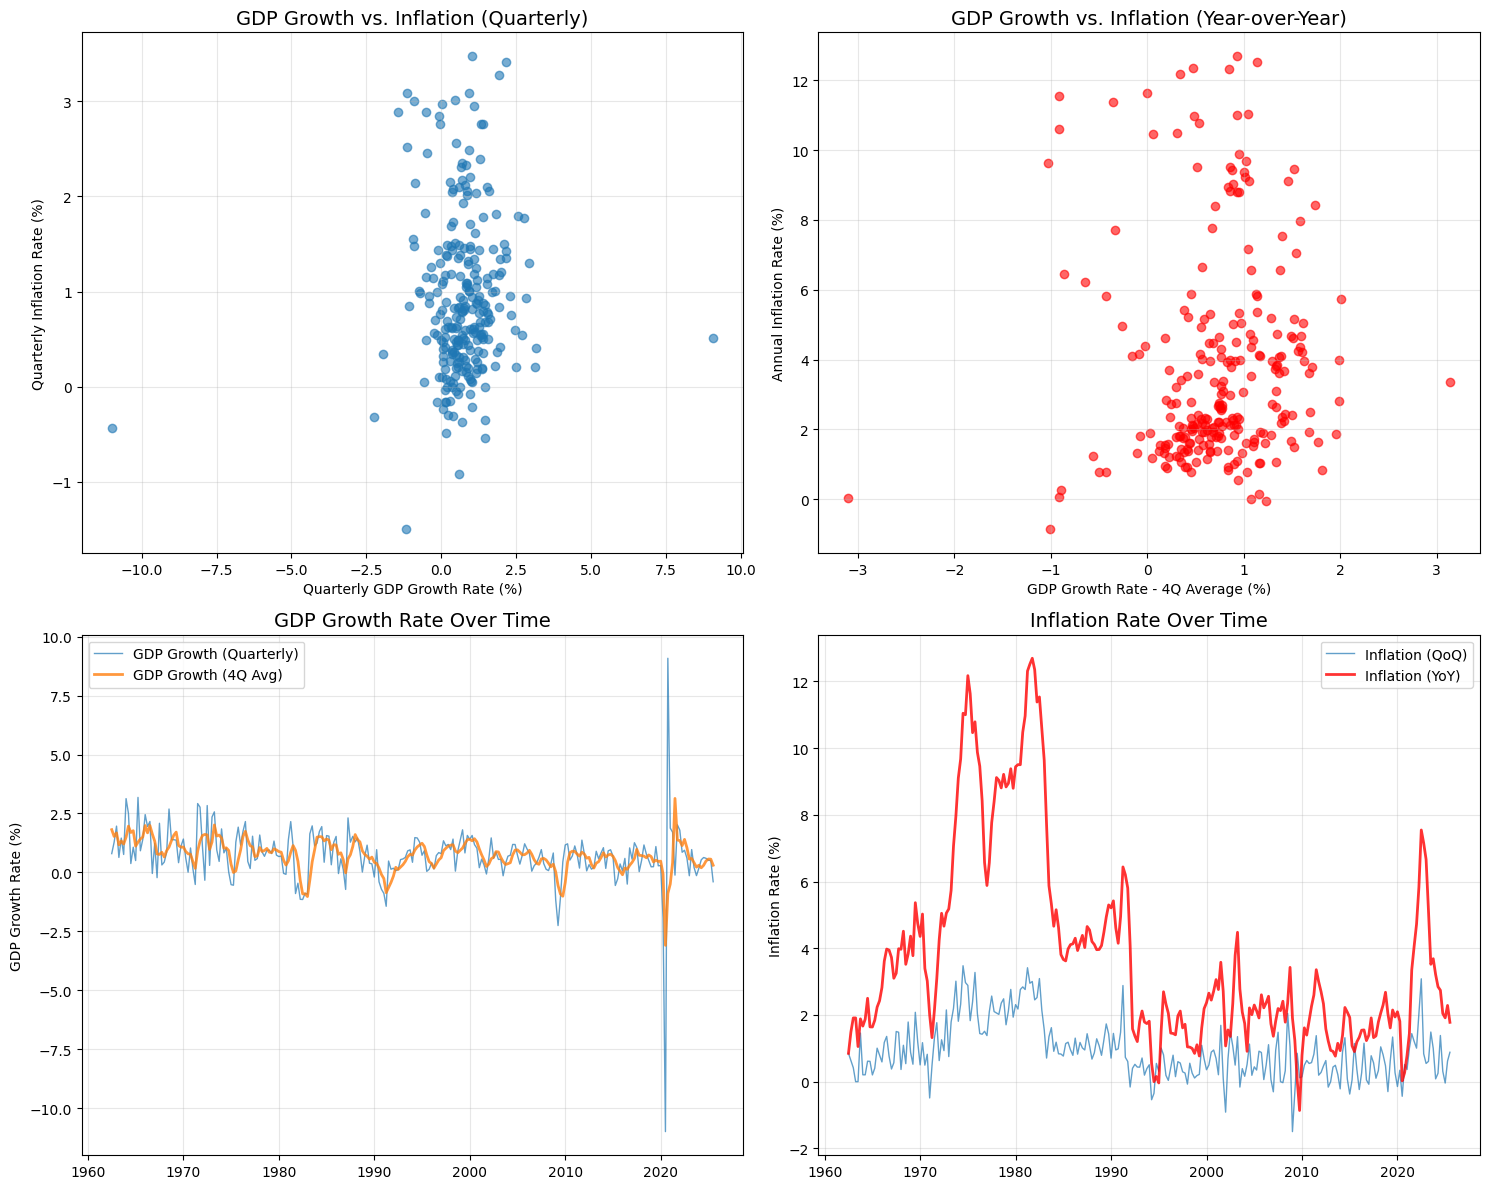

In [8]:
# Create comprehensive plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Quarter-over-quarter comparison (GDP quarterly vs Inflation quarterly)
ax1.scatter(final_df_clean['GDP_Growth_Rate'], final_df_clean['Inflation_Rate_QoQ'], alpha=0.6)
ax1.set_title('GDP Growth vs. Inflation (Quarterly)', fontsize=14)
ax1.set_xlabel('Quarterly GDP Growth Rate (%)')
ax1.set_ylabel('Quarterly Inflation Rate (%)')
ax1.grid(True, alpha=0.3)

# Year-over-year comparison 
ax2.scatter(final_df_clean['GDP_Growth_Rate_YoY'], final_df_clean['Inflation_Rate_YoY'], alpha=0.6, color='red')
ax2.set_title('GDP Growth vs. Inflation (Year-over-Year)', fontsize=14)
ax2.set_xlabel('GDP Growth Rate - 4Q Average (%)')
ax2.set_ylabel('Annual Inflation Rate (%)')
ax2.grid(True, alpha=0.3)

# Time series of both variables
ax3.plot(final_df_clean.index, final_df_clean['GDP_Growth_Rate'], label='GDP Growth (Quarterly)', alpha=0.7, linewidth=1)
ax3.plot(final_df_clean.index, final_df_clean['GDP_Growth_Rate_YoY'], label='GDP Growth (4Q Avg)', alpha=0.8, linewidth=2)
ax3.set_title('GDP Growth Rate Over Time', fontsize=14)
ax3.set_ylabel('GDP Growth Rate (%)')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Time series of inflation
ax4.plot(final_df_clean.index, final_df_clean['Inflation_Rate_QoQ'], label='Inflation (QoQ)', alpha=0.7, linewidth=1)
ax4.plot(final_df_clean.index, final_df_clean['Inflation_Rate_YoY'], label='Inflation (YoY)', color='red', alpha=0.8, linewidth=2)
ax4.set_title('Inflation Rate Over Time', fontsize=14)
ax4.set_ylabel('Inflation Rate (%)')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.savefig('gdp_inflation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Statistical Analysis & Conclusion
Finally, we calculate the Pearson correlation coefficient to get a quantitative measure of the linear relationship between our variables and provide a final conclusion.

In [9]:
# Print correlations
correlation_qoq = final_df_clean['GDP_Growth_Rate'].corr(final_df_clean['Inflation_Rate_QoQ'])
correlation_yoy = final_df_clean['GDP_Growth_Rate_YoY'].corr(final_df_clean['Inflation_Rate_YoY'])

print(f"Correlation Analysis:")
print(f"Quarterly GDP vs Quarterly Inflation: {correlation_qoq:.3f}")
print(f"4Q Avg GDP vs YoY Inflation: {correlation_yoy:.3f}")

Correlation Analysis:
Quarterly GDP vs Quarterly Inflation: 0.051
4Q Avg GDP vs YoY Inflation: 0.046


## 7. Conclusion

Based on the analysis of Canadian economic data from 1961 to 2025, the initial hypothesis that higher GDP growth is associated with higher inflation is **not supported**.

1.  **No Short-Term Relationship**: The correlation between Quarter-over-Quarter GDP growth and inflation is **0.051**. A value this close to zero is considered statistically insignificant and indicates no meaningful linear relationship.

2.  **No Long-Term Relationship**: The correlation between the 4-quarter average GDP growth and Year-over-Year inflation is **0.046**. This value is also effectively zero, confirming that there is no significant long-term linear relationship in the data.

3.  **Final Interpretation**: The textbook economic relationship between growth and inflation is not clearly visible in the historical data. This is likely due to the complexity of the modern economy where many other factors (e.g., global supply chains, monetary policy, consumer expectations) play a more significant role.